In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,9730a14f-888a-4f61-a76d-484ed7752da9,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_standard
1,trained,logistic_regression,Transformer,,-1,-1,20,12,8,logistic_regression_standard
2,trained,noisy_logistic_regression_train0.2,Transformer,train_noise_prob=0.2,-1,-1,20,12,8,noisy_logistic_regression_train0.2
3,trained,noisy_rbf_logistic_regression_train0.2,Transformer,train_noise_prob=0.2,-1,-1,20,12,8,noisy_rbf_logistic_regression_train0.2
4,trained,rbf_logistic_regression,Transformer,,-1,-1,20,12,8,rbf_logistic_regression_standard


In [92]:
# task = "noisy_logistic_regression_train0.2"
# task = "noisy_rbf_logistic_regression_train0.2"
task = "logistic_regression"
# task = "rbf_logistic_regression"

run_id = "trained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [86]:
tasks = ["logistic_regression", "rbf_logistic_regression", "noisy_logistic_regression_train0.2", \
         "noisy_rbf_logistic_regression_train0.2"]

for t in tasks:
    print("task name:", t)

    def valid_row(r):
        return r.task == t and r.run_id == run_id

    metrics = collect_results(run_dir, df, valid_row=valid_row)['standard']
    for num_ex in [10, 20, 40]:
        print(num_ex)
        for k, v in metrics.items():
            print(k, round(v['mean'][num_ex], 4))

task name: logistic_regression
logistic_regression_standard trained


100%|██████████| 1/1 [00:00<?, ?it/s]


10
Transformer 0.6727
Logistic Regression 0.6477
3-Nearest Neighbors 0.6047
LDA 0.5602
SVM 0.6555
20
Transformer 0.7383
Logistic Regression 0.7484
3-Nearest Neighbors 0.6523
LDA 0.6273
SVM 0.7289
40
Transformer 0.8266
Logistic Regression 0.8109
3-Nearest Neighbors 0.643
LDA 0.8055
SVM 0.8047
task name: rbf_logistic_regression
rbf_logistic_regression_standard trained


100%|██████████| 1/1 [00:00<?, ?it/s]


10
Transformer 0.7336
3-Nearest Neighbors 0.5344
Gaussian Process Classifier 0.4773
Gaussian Process Classifier (RBF) 0.5109
SVM (RBF) 0.4898
3-Nearest Neighbors (RBF) 0.5672
20
Transformer 0.7281
3-Nearest Neighbors 0.5781
Gaussian Process Classifier 0.4852
Gaussian Process Classifier (RBF) 0.4625
SVM (RBF) 0.6086
3-Nearest Neighbors (RBF) 0.5758
40
Transformer 0.9828
3-Nearest Neighbors 0.6195
Gaussian Process Classifier 0.5141
Gaussian Process Classifier (RBF) 0.4992
SVM (RBF) 0.7195
3-Nearest Neighbors (RBF) 0.6031
task name: noisy_logistic_regression_train0.2
noisy_logistic_regression_train0.2 trained


100%|██████████| 1/1 [00:00<00:00, 625.92it/s]


10
Transformer 0.4977
Logistic Regression 0.6953
3-Nearest Neighbors 0.5844
LDA 0.5617
SVM 0.6406
20
Transformer 0.4914
Logistic Regression 0.7477
3-Nearest Neighbors 0.6117
LDA 0.618
SVM 0.7156
40
Transformer 0.5297
Logistic Regression 0.8266
3-Nearest Neighbors 0.6602
LDA 0.782
SVM 0.7992
task name: noisy_rbf_logistic_regression_train0.2
noisy_rbf_logistic_regression_train0.2 trained


100%|██████████| 1/1 [00:00<?, ?it/s]

10
Transformer 0.6906
Logistic Regression (RBF) 0.6211
Logistic Regression 0.5992
3-Nearest Neighbors 0.5453
Gaussian Process Classifier 0.4883
Gaussian Process Classifier (RBF) 0.4789
SVM (RBF) 0.5188
3-Nearest Neighbors (RBF) 0.5555
20
Transformer 0.6977
Logistic Regression (RBF) 0.6953
Logistic Regression 0.6383
3-Nearest Neighbors 0.5789
Gaussian Process Classifier 0.475
Gaussian Process Classifier (RBF) 0.4898
SVM (RBF) 0.6008
3-Nearest Neighbors (RBF) 0.5945
40
Transformer 0.6773
Logistic Regression (RBF) 0.7242
Logistic Regression 0.7008
3-Nearest Neighbors 0.5789
Gaussian Process Classifier 0.5109
Gaussian Process Classifier (RBF) 0.4852
SVM (RBF) 0.6961
3-Nearest Neighbors (RBF) 0.6086


# Plot pre-computed metrics

rbf_logistic_regression_standard trained


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


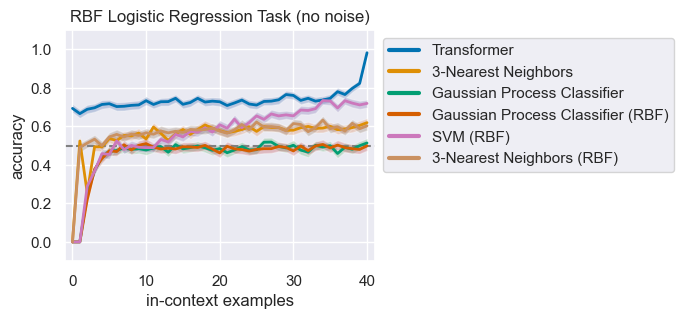

In [62]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = metrics["standard"].keys()
basic_plot(metrics["standard"], y_axis_name="accuracy", models=models, trivial=0.5)
plt.title("RBF Logistic Regression Task (no noise)")
plt.show()

In [15]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [14]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [15]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [16]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [21]:
with torch.no_grad():
    pred = model(xs, ys)

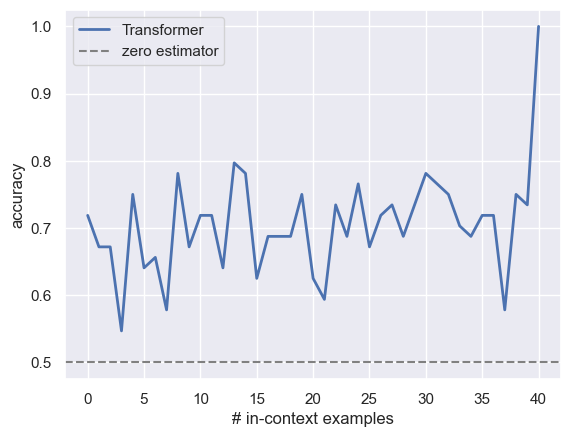

In [22]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "rbf_logistic_regression": 0.5,
    "noisy_rbf_logistic_regression": 0.5
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [23]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

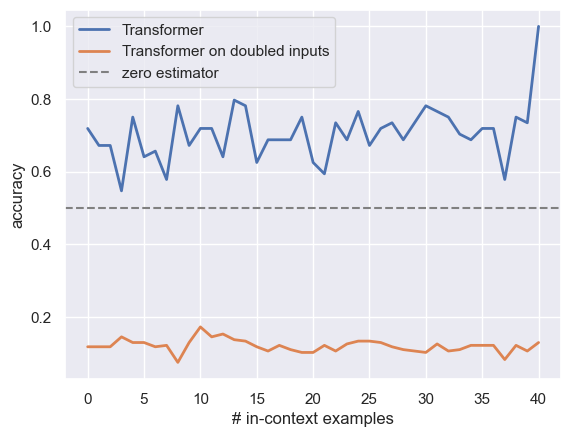

In [24]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

For classification, the model is not robust when we double all the inputs.

In [93]:
from analysis.query_scale import *
import numpy as np

In [94]:
mdl, conf = get_model_from_run(run_path)

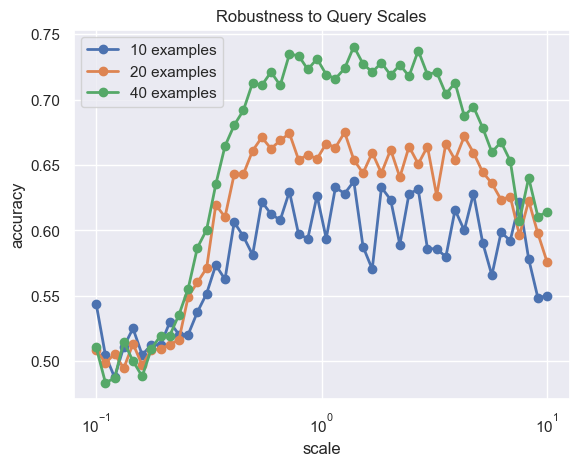

In [95]:
query_scale(mdl, conf, np.geomspace(0.1, 10, 50))